<a href="https://colab.research.google.com/github/jinjukang67/AIFFEL_Project/blob/master/GD_2_Naver_review_Sentencepiece_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화 리뷰 감성 분석 프로젝트 : SentencePiece 적용해 보기

## Step 1. SentencePiece 설치하기
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece
!pip install wget

     |████████████████████████████████| 1.2 MB 7.8 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fc0bab4f77c0c7cdc651318b74d4939863c7d8b611c2ed2d968c4d7d5d316247
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


## Step 2. SentencePiece 모델 학습

### 1) 데이터 준비하기
터미널로 데이터 폴더 생성하기
```
! bash
cd /drive/MyDrive/Aiffel
mkdir -p sp_tokenizer/data
exit
```

In [3]:
# !bash

In [4]:
# data를 저장할 폴더 경로
data_dir = "/content/drive/MyDrive/Aiffel/sp_tokenizer/data"

In [5]:
# 라이브러리 Import
import os
import json
import pandas as pd
import sentencepiece as spm
import wget
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import urllib.request
import csv

%matplotlib inline

In [6]:
# filename = wget.download("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", f"{data_dir}")
# print(filename)
# filename = wget.download("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", f"{data_dir}")
# print(filename)
for f in os.listdir(data_dir):
  print(f)

ratings_train.txt
ratings_test.txt
ratings_train.csv
ratings_txt
ratings_train_temp.txt
ratings_train_temp2.txt
ratings_train_temp3.txt
ratings_train_temp4.txt


### 2) Korpora가 뭔지 알아보기
> - **Korpora(한국어 코퍼스 데이터 오픈소스 파이썬 패키지)** 한번 사용해보기
> - Sentence Piece 사용하자

[Korpora 깃헙](https://github.com/ko-nlp/Korpora)<br>
[Korpora 빠른 사용법](https://ko-nlp.github.io/Korpora/ko-docs/introduction/quicktour.html)

In [7]:
!git

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect     Use binary search to find the commit that introduced a bug
   grep       Prin

In [8]:
!pip install Korpora

     |████████████████████████████████| 57 kB 4.7 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [9]:
from Korpora import Korpora

# Korpora.fetch("all") -> Korpora가 제공하는 모든 말뭉치 내려 받을 수 있음
Korpora.fetch("nsmc") # 네이버 영화 리뷰 데이터로만 일단 단어장 사용해보자!
corpus = Korpora.load("nsmc")

[nsmc] download ratings_train.txt: 14.6MB [00:00, 121MB/s]                             
[nsmc] download ratings_test.txt: 4.90MB [00:00, 23.8MB/s]                            



    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at /root/Korpora/nsmc/ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at /root/Korpora/nsmc/ra

In [10]:
corpus

> - **Korpora**는 그냥 다양한 한국어 코퍼스 데이터를 쉽게 다운로드, 사용할 수만 있는 기능만 제공
> - 터미널에서 전체 데이터로 다운로드 전처리 하려면
```
korpora lmdata \
  --corpus all \
  --output_dir ~/works/lmdata
```

> - 네이버 영화 리뷰 데이터는 이미 위에서 준비 완료했으므로 1회 실습 후 더 큰 데이터를 **Korpora**에서 불러와 Vocab 만들어 실습 진행해보자

### 3) 데이터 정제하기

`rating_train_txt` document만 뽑아기
> - 데이터프레임으로 바꿔서 csv 파일로 저장한 후 
> - 다시 txt 파일 형태로 바꿔서 저장하자.

=> 오류나서 실패^^ <br>
=> 그냥 for문으로 split() 써서 가져왔는데 더 간단한 방법이 있었다.

이렇게 쉽게 가져오는 방법도 있었다^^
```
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))

```

In [11]:
# temp = pd.read_table(path_to_file)
# temp.head()

# temp.to_csv(data_dir + '/ratings_train.csv', index=False, header=True)

In [12]:
# csv 파일d text로 변환 후 document만 가져오기 - 실패
'''
import shutil

in_file = f"{data_dir}/ratings_train.csv"
out_file = f"{data_dir}/ratings_train_f.txt"
SEPARATOR = u"\u241D"

if not os.path.isfile(out_file):
    df = pd.read_csv(in_file, sep=SEPARATOR, engine="python")
    with open(out_file, "w") as f:
      for index, row in df.iterrows():
        f.write(row["document"]) # document만 가져오기
        f.write("\n\n\n\n") # 구분자

shutil.copy(out_file, "ratings_train_f.txt")
'''

'\nimport shutil\n\nin_file = f"{data_dir}/ratings_train.csv"\nout_file = f"{data_dir}/ratings_train_f.txt"\nSEPARATOR = u"␝"\n\nif not os.path.isfile(out_file):\n    df = pd.read_csv(in_file, sep=SEPARATOR, engine="python")\n    with open(out_file, "w") as f:\n      for index, row in df.iterrows():\n        f.write(row["document"]) # document만 가져오기\n        f.write("\n\n\n\n") # 구분자\n\nshutil.copy(out_file, "ratings_train_f.txt")\n'

In [13]:
path_to_file = data_dir + "/ratings_train.txt"

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[1:100][::20]: print(">>", sen.split('	')[1])

Data Size: 150001
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


In [14]:
# X_train 데이터
ratings = [] 
for sen in raw[1:]: 
    ratings.append(sen.split('	')[1])

In [15]:
# 라벨 데이터 y_train
y_train = []
for sen in raw[1:]:
    y_train.append(int(sen.split('	')[2]))

y_train[:20]

[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]

In [16]:
len(ratings)

150000

In [17]:
# test 데이터셋 가져오기 1
test_path = data_dir + "/ratings_test.txt"
X_test = []
with open(test_path, "r") as f:
    raw_t = f.read().splitlines()

for sen in raw_t[1:]:
    X_test.append(sen.split('	')[1])

y_test = []
for sen in raw_t[1:]:
    y_test.append(int(sen.split('	')[2]))

print("X_test data Size:", len(X_test))
print("y_test data Size:", len(y_test))
print(X_test[:10])
print(y_test[:10])

X_test data Size: 50000
y_test data Size: 50000
['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', '지루하지는 않은데 완전 막장임... 돈주고 보기에는....', '3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??', '음악이 주가 된, 최고의 음악영화', '진정한 쓰레기', '마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다', '갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다', '이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..']
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


In [18]:
# test 데이터셋 가져오기 2
test_path = data_dir + "/ratings_test.txt"

test_data =pd.read_table(test_path)
test_data = test_data.dropna(how = 'any')
test_data.drop_duplicates(subset=['document'],inplace=True)

print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(test_data['document'].nunique())
print(len(test_data))

False
49157
49157


문장의 최단 길이: 0
문장의 최장 길이: 158
문장의 평균 길이: 35
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
[ 607 1071 1306 1544 1445 1653 1919 1867 1834 2636 3408 4352 4468 4471
 4180 3928 3699 3750 3570 3499 3428 3330 3203 3074 2976 2975 2887 2898
 2821 2766 2696 2668 2539 2497 2277 2126 2079 2064 2039 2132 1923 1904
 1881 1969 1933 1676 1234  966  837  716  668  625  615  618  599  502
  557  484  508  483  465  428  453  416  428  408  411  402  341  371
  306  358  334  321  300  323  307  289  301  270  285  279  291  285
  243  266  233  229  260  260  192  212  216  217  207  188  208  211
  212  182  173  179  159  176  175  178  183  167  161  141  142  160
  147  168  145  125  142  159  135  146  155  133  161  150  161  1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


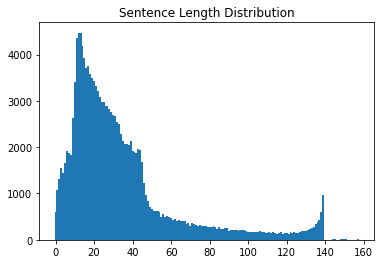

In [19]:
# 데이터 문장 길이 분포 시각화
min_len = 999
max_len = 0
sum_len = 0

for sen in ratings:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

print(sentence_length)

for sen in ratings:
    sentence_length[len(sen)-1] += 1 # 문장 길이 빈도수 표현

print(sentence_length)
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [20]:
# 1) 최단 길이가 0이 왜 나와?
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# check_sentence_with_length(ratings, 1)

In [21]:
check_sentence_with_length(ratings, 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
쵝오
최고
굿!
별루
씐나
쓰렉
최고
볼만
허접
최고
비추
좋다
ㅎㅎ
아나
최고
ㅉㅉ
야.
역시
^^
대박
오오
최고
평이
지루
안습
오욈
ㅋㅋ
지송
별로
눈물
당연
좋다
쩔어
별노
최고
몰입
별로
졸잼
ㅋㅋ
쵝오
돋네
별로
오글
이응
최고
첨봄
최악
잼씀
ok
유후
최악
별루
감동
최고
gg
;;
조앙
최고
최고
졸작
1점
표절
명작
별루
으휴
최악
에효
굿!
gg
최악
볼만
별로
ㄱ굿
^^
굿잡
잼나
눈물
10
ㅜㅜ
우왕
쩔어
거지
굿굿
굳굳
좋음
10
실망
비추
굿.
최악
^^


In [22]:
# check_sentence_with_length(ratings, 60)

> - 최단길이가 0인걸 봐서는 공백이 들어간거 같다, 공백은 제거하자
> - 굿,굳과 같은 단어는 긍정의 의미 담고 있으니까 길이 1이라도 없애지 말자.

In [23]:
# 문장의 길이가 같은 문장이 2000개 초과하는 sentence_length는 뭘까?
for idx, _sum in enumerate(sentence_length):
    if _sum > 3000:
        print("Outlier Index: ",idx+1)

Outlier Index:  11
Outlier Index:  12
Outlier Index:  13
Outlier Index:  14
Outlier Index:  15
Outlier Index:  16
Outlier Index:  17
Outlier Index:  18
Outlier Index:  19
Outlier Index:  20
Outlier Index:  21
Outlier Index:  22
Outlier Index:  23
Outlier Index:  24


In [24]:
# check_sentence_with_length(ratings, 24)

Data Size: 146183
문장의 최단 길이: 0
문장의 최장 길이: 158
문장의 평균 길이: 36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


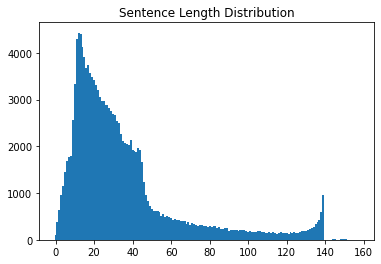

In [25]:
# 중복 있을 수도 있으니 제거해보자
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(ratings))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [26]:
print("중복된 값: ",len(ratings) - len(cleaned_corpus))

중복된 값:  3817


> - 150,000 개에서 중복된 데이터 3817개를 제거하여 146,183개로 줄었다.

1. 네이버 영화 후기의 경우 길이가 1,2 로 짧아도 감정이 드러나기 때문에 min_len 은 1로 하자.
2. 후기니까 문장 길이 80이상은 제거하자.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


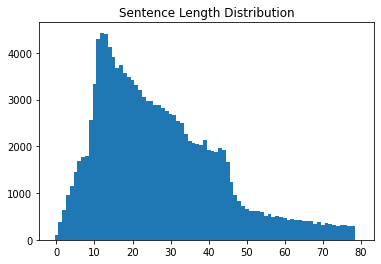

In [27]:
max_len = 80
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다. -> 최종적인 데이터 분포
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### Konlpy로 형태소 분석해보면?

In [28]:
# mecab 설치하기
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 https://cloud.r-project.org/bin/linux/u

In [29]:
#  mecab.morphs()를 사용해서 형태소 분석
from konlpy.tag import Mecab

mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [30]:
# corpus: Tokenized Sentence's List
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [31]:
# 단어 사전 길이 확인
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 45378


mecab 테스트 해보기

In [32]:
# Case 1
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[300]])

print(texts[0])

최고 ! 다른 말 이 필요 없 어요 .


In [33]:
# Case 2
sentence = ""

for w in mecab_tensor[300]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + ""

print(sentence)

최고!다른말이필요없어요.


In [34]:
test = mecab_tokenizer.texts_to_sequences("줄거리에 다써놨어 ㅋㅋㅋ ㅁ ㅣ친 ㄴ ㅔ이버")
test

[[130],
 [57],
 [898],
 [12],
 [],
 [5],
 [1121],
 [2200],
 [44],
 [],
 [129],
 [129],
 [129],
 [],
 [1169],
 [],
 [1638],
 [2330],
 [],
 [846],
 [],
 [14379],
 [2],
 [1474]]

In [35]:
result = mecab_tokenizer.sequences_to_texts(test)
print(result)

['줄', '거', '리', '에', '', '다', '써', '놨', '어', '', 'ㅋ', 'ㅋ', 'ㅋ', '', 'ㅁ', '', 'ㅣ', '친', '', 'ㄴ', '', 'ㅔ', '이', '버']


# 불용어 제거 어디서 어떻게 하지?

### 4) Sentence Piece를 이용해서 Vocab 파일을 만들기


In [36]:
data_dir

'/content/drive/MyDrive/Aiffel/sp_tokenizer/data'

In [37]:
filtered_corpus[:10]

['사랑. 그거 하나면 족하다.',
 '이 영화는 -영화가 무엇을 말하려는가를 떠나서- 진짜 보면 볼수록 소름 돋을 정도로 잘 만든 영화다!',
 '재미없다.. 킬링타임용으로도 못 봐주겠다.',
 '존내 웃겼음 대박이였음',
 '슈주짱 샤이니짱 에셈짱♥♥',
 '어렷을 때 동화를 읽은 느낌을 성인이되서 느꼈다고 할까? 계속 생각남',
 '저 믿고 절대 보지마세요, 윤하땜에 꾹 참고 끝까지 봤는데, 허무 그 자체...',
 '프린스&프린세스 완전 좋아했었음. 따뜻하고 왠지 인간적인 그림자애니매이션. 아날로그 감성 충만하다면 꼭 보세요',
 '전문 성우좀 씁시다. 밥그릇 다 뺏어가네',
 '작가가 제이슨이 외동아들이란걸 까먹고 만든, 스토리 엉성해진 영화']

In [38]:
import sentencepiece as spm
import os
temp_file = data_dir + '/ratings_train_temp4.txt'

vocab_size = 10000
model_name = 'rating_cor4'

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    "--input={} --model_prefix={} --vocab_size={}".format(temp_file, model_name, vocab_size) +
    " --model_type=char" + # Train에서  --model_type = 'unigram'이 디폴트, --model_type = 'bpe' 로 옵션을 주어 변경 가능.
    " --max_sentence_length=80" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" ) # end of sequence (3)

!ls -l rating_cor4*

-rw-r--r-- 1 root root 258841 Mar 24 02:40 rating_cor4.model
-rw-r--r-- 1 root root  22662 Mar 24 02:40 rating_cor4.vocab


In [39]:
s = spm.SentencePieceProcessor()
s.Load('rating_cor4.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('줄거리에 다써놨어 ㅋㅋㅋ ㅁ ㅣ친 ㄴ ㅔ이버')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('줄거리에 다써놨어 ㅋㅋㅋ ㅁ ㅣ친 ㄴ ㅔ이버',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[4, 230, 71, 32, 24, 4, 7, 530, 879, 23, 4, 17, 17, 17, 4, 694, 4, 830, 328, 4, 599, 4, 1162, 6, 201]
[]
줄거리에 다써놨어 ᄏᄏᄏ ᄆ ᅵ친 ᄂ ᅦ이버


## Step 3. Tokenizer 함수 작정
-  위에서 훈련시킨 SentencePiece를 활용
> 1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 **온전한 문장**의 list를 전달한다.
> 2. **생성된 vocab 파일** 읽어와 `{ <word> : <idx> }` 형태를 가지는 `word_index` 사전과 `{ <idx> : <word>}` 형태를 가지는 `index_word` 사전을 생성하고 함께 **반환**합니다.
> 3. 리턴값인 `tensor` 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야합니다.

In [40]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./rating_cor4.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre') # RNN에는 'pre'가 더 유리하다

    return tensor, word_index, index_word

In [41]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("Tensor:",tensor)
print("Word_index:",word_index)
print("Index_word:",index_word)

Tensor: [[   0    0    0    0    0    0    0    0    0    4   21    9    4  771
    40    4  302   75  136   33    7    5]
 [   4   43  117   21    4   86   62  145    4   83   83    4  144   15
     4   12 1642   33    7    5    5    5]]
Word_index: {0: '[PAD]', 1: '[UNK]', 2: '[BOS]', 3: '[EOS]', 4: '▁', 5: '.', 6: '이', 7: '다', 8: '화', 9: '는', 10: '영', 11: '지', 12: '고', 13: '!', 14: '하', 15: '가', 16: '아', 17: 'ᄏ', 18: '도', 19: '재', 20: '기', 21: '나', 22: '한', 23: '어', 24: '에', 25: '요', 26: '의', 27: '보', 28: '만', 29: '은', 30: '게', 31: '미', 32: '리', 33: '니', 34: '라', 35: '로', 36: '~', 37: '없', 38: '무', 39: '시', 40: '을', 41: '?', 42: '점', 43: '그', 44: '서', 45: '스', 46: '인', 47: '네', 48: '말', 49: '정', 50: '들', 51: '있', 52: '진', 53: ',', 54: '데', 55: '음', 56: '대', 57: '마', 58: '좋', 59: '감', 60: '해', 61: '내', 62: '전', 63: '최', 64: '너', 65: '1', 66: '수', 67: '면', 68: '밌', 69: '작', 70: '사', 71: '거', 72: '자', 73: '연', 74: '주', 75: '었', 76: '드', 77: '0', 78: '짜', 79: '오', 80: '야', 81: '우', 82: 

## 데이터 로더 함수 만들기
- 데이터 정규표현식 전처리 함수 만들기
- 데이터 중복 제거
- 데이터 결측치 제거
- 불용어 처리
- sp_tokenize로 



> - 한글 불용어 파이썬 라이브러리 없기때문에 직접 불용어 사전 만들어 제거하자!
> -  한국어 불용어 리스트 100개 txt 파일 쓰는 방법도 있음!

[한국어 불용어 리스트 100개](https://bab2min.tistory.com/544)

In [42]:
# raw 데이터 불러와서 시작하자
path_to_file = data_dir + "/ratings_train.txt"
test_path = data_dir + "/ratings_test.txt"

train_d = pd.read_table(path_to_file)
test_d = pd.read_table(test_path)

train_d.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
import re

# 불용어 사전 만들기
stopwords = set(['하','아','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'])

def preprocess_data(sentence):
    # 한글 및 공백 이외 다른 문자 모두 제거.
    sentence = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sentence)
    return sentence

def load_data(train_data, test_data, num_words=10000):

    # train/test의 중복, 결측치 제거, 한글 및 공백 이외 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) 
    train_data['document'] = train_data['document'].apply(lambda x: preprocess_data(str(x)))
    train_data = train_data.dropna(how = 'any')

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].apply(lambda x: preprocess_data(str(x)))
    test_data = test_data.dropna(how = 'any') 

    train_list = []
    for sentence in train_data['document']:
        # temp_X = s.encode_as_pieces(sentence) # 토큰화
        # temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        # temp_X = s.encode_as_ids(sentence)
        train_list.append(sentence)

    test_list = []
    for sentence in test_data['document']:
        # temp_X = s.encode_as_pieces(sentence) # 토큰화
        # temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        # temp_X = s.encode_as_ids(sentence)
        test_list.append(sentence)
    
    X_train, word_to_index, index_to_word = sp_tokenize(s, train_list)
    X_test , _,_ = sp_tokenize(s, test_list)

        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_d, test_d) 

In [44]:
X_train

array([[  0,   0,   0, ..., 357, 115,  32],
       [  0,   0,   0, ..., 135, 103,  21],
       [  0,   0,   0, ..., 281,  22,   7],
       ...,
       [  0,   0,   0, ..., 679,  14,   7],
       [  0,   0,   0, ...,  72,   8,  91],
       [  0,   0,   0, ...,   4,  10,   8]], dtype=int32)

In [45]:
y_train

array([0, 1, 0, ..., 0, 1, 0])

In [46]:
X_test

array([[  0,   0,   0, ..., 509,   4,  17],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  33, 557,  16],
       ...,
       [  0,   0,   0, ...,  28, 199,   7],
       [  0,   0,   0, ...,  60, 302,  47],
       [  0,   0,   0, ..., 125,   6, 149]], dtype=int32)

In [47]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [48]:
# word_to_index

## Step 4. 모델 구성하기
- 1. LSTM 
- 2. 1-D CNN
- 3. GlobalMaxPooling1D() 레이어 하나만 쓰기
- 4. Transformer 이용 (시간 더 있을 시)

**LSTM 모델 구성**

In [49]:
# LSTM 모델
vocab_size = 8000
word_vector_dim = 32 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          256000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 282,945
Trainable params: 282,945
Non-trainable params: 0
_________________________________________________________________


**1-D CNN 모델 구성**

In [50]:
# 1-D CNN으로 만든 모델 구현

model_1dc = tf.keras.Sequential()
model_1dc.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dc.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) # word_vector_dim과 맞춰봤습니다.
model_1dc.add(tf.keras.layers.MaxPooling1D(5))
model_1dc.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) # word_vector_dim과 맞춰봤습니다.
model_1dc.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dc.add(tf.keras.layers.Dense(16, activation='relu'))
model_1dc.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1dc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          256000    
                                                                 
 conv1d (Conv1D)             (None, None, 32)          7200      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 16)               

**GlobalMaxPooling1D() 레이어만 사용한 모델**





In [51]:
# GlobalMaxPolling만 있는 것 

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(16, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          256000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,545
Trainable params: 256,545
Non-trainable params: 0
_________________________________________________________________


**Validations set 구분**

In [52]:
# train_test_split으로 나눠보겠습니다.
from sklearn.model_selection import train_test_split

xx_train, xx_validation, yy_train, yy_validation = train_test_split(X_train,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                   random_state=2022)

In [53]:
# 에포크
EPOCHS = 10

### 1. LSTM


In [54]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_lstm.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 10s - loss: 0.5213 - accuracy: 0.7425 - val_loss: 0.4586 - val_accuracy: 0.7848 - 10s/epoch - 42ms/step
Epoch 2/10
229/229 - 4s - loss: 0.4454 - accuracy: 0.7930 - val_loss: 0.4454 - val_accuracy: 0.7921 - 4s/epoch - 17ms/step
Epoch 3/10
229/229 - 4s - loss: 0.4269 - accuracy: 0.8020 - val_loss: 0.4282 - val_accuracy: 0.7995 - 4s/epoch - 15ms/step
Epoch 4/10
229/229 - 4s - loss: 0.4109 - accuracy: 0.8099 - val_loss: 0.4150 - val_accuracy: 0.8062 - 4s/epoch - 17ms/step
Epoch 5/10
229/229 - 4s - loss: 0.3985 - accuracy: 0.8164 - val_loss: 0.4079 - val_accuracy: 0.8113 - 4s/epoch - 15ms/step
Epoch 6/10
229/229 - 3s - loss: 0.3848 - accuracy: 0.8238 - val_loss: 0.4028 - val_accuracy: 0.8164 - 3s/epoch - 15ms/step
Epoch 7/10
229/229 - 4s - loss: 0.3748 - accuracy: 0.8292 - val_loss: 0.3969 - val_accuracy: 0.8166 - 4s/epoch - 15ms/step
Epoch 8/10
229/229 - 4s - loss: 0.3660 - accuracy: 0.8341 - val_loss: 0.3932 - val_accuracy: 0.8200 - 4s/epoch - 16ms/step
Epoch 9/10
229

In [55]:
# test 셋으로 평가해보기
results = model_lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3846 - accuracy: 0.8242 - 5s/epoch - 3ms/step
[0.3846341669559479, 0.8241588473320007]


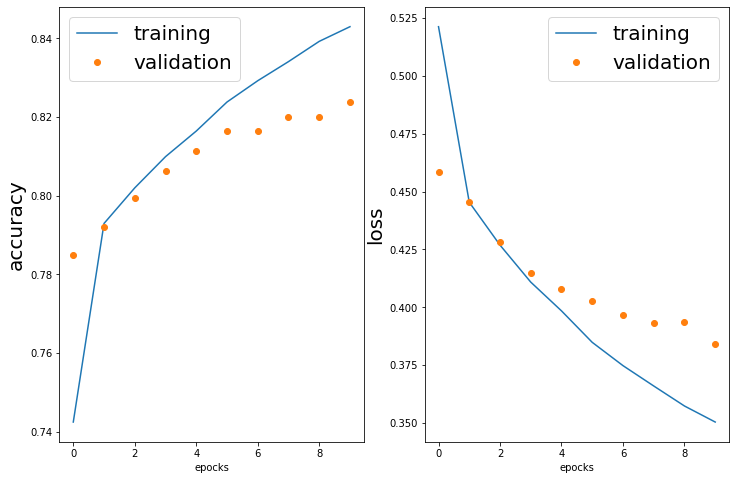

In [56]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

### 2. 1-D CNN

In [57]:
model_1dc.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_1dc.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 8s - loss: 0.5214 - accuracy: 0.7297 - val_loss: 0.4278 - val_accuracy: 0.8001 - 8s/epoch - 37ms/step
Epoch 2/10
229/229 - 2s - loss: 0.3982 - accuracy: 0.8181 - val_loss: 0.3935 - val_accuracy: 0.8201 - 2s/epoch - 10ms/step
Epoch 3/10
229/229 - 2s - loss: 0.3600 - accuracy: 0.8410 - val_loss: 0.3956 - val_accuracy: 0.8229 - 2s/epoch - 10ms/step
Epoch 4/10
229/229 - 2s - loss: 0.3334 - accuracy: 0.8544 - val_loss: 0.3856 - val_accuracy: 0.8294 - 2s/epoch - 10ms/step
Epoch 5/10
229/229 - 2s - loss: 0.3104 - accuracy: 0.8690 - val_loss: 0.3777 - val_accuracy: 0.8342 - 2s/epoch - 10ms/step
Epoch 6/10
229/229 - 2s - loss: 0.2909 - accuracy: 0.8797 - val_loss: 0.3828 - val_accuracy: 0.8349 - 2s/epoch - 10ms/step
Epoch 7/10
229/229 - 2s - loss: 0.2721 - accuracy: 0.8894 - val_loss: 0.3909 - val_accuracy: 0.8323 - 2s/epoch - 10ms/step
Epoch 8/10
229/229 - 3s - loss: 0.2544 - accuracy: 0.8988 - val_loss: 0.3976 - val_accuracy: 0.8305 - 3s/epoch - 11ms/step
Epoch 9/10
229/2

In [58]:
# test 셋으로 평가해보기
results = model_1dc.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4529 - accuracy: 0.8168 - 3s/epoch - 2ms/step
[0.4529258608818054, 0.8168151378631592]


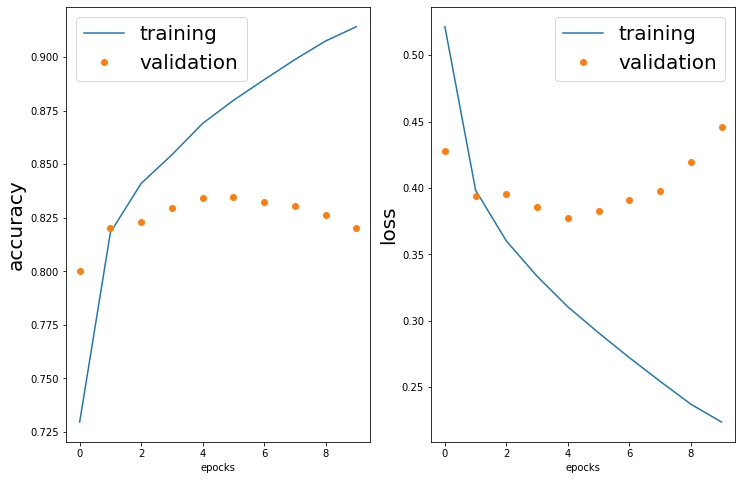

In [59]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()


### 3. Global Max Pooling

In [60]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_gmp.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 2s - loss: 0.5807 - accuracy: 0.7245 - val_loss: 0.4772 - val_accuracy: 0.7707 - 2s/epoch - 9ms/step
Epoch 2/10
229/229 - 2s - loss: 0.4560 - accuracy: 0.7856 - val_loss: 0.4559 - val_accuracy: 0.7854 - 2s/epoch - 8ms/step
Epoch 3/10
229/229 - 1s - loss: 0.4345 - accuracy: 0.7988 - val_loss: 0.4490 - val_accuracy: 0.7895 - 1s/epoch - 7ms/step
Epoch 4/10
229/229 - 1s - loss: 0.4208 - accuracy: 0.8060 - val_loss: 0.4448 - val_accuracy: 0.7909 - 1s/epoch - 5ms/step
Epoch 5/10
229/229 - 1s - loss: 0.4099 - accuracy: 0.8122 - val_loss: 0.4434 - val_accuracy: 0.7920 - 1s/epoch - 5ms/step
Epoch 6/10
229/229 - 1s - loss: 0.4009 - accuracy: 0.8173 - val_loss: 0.4416 - val_accuracy: 0.7935 - 1s/epoch - 5ms/step
Epoch 7/10
229/229 - 1s - loss: 0.3937 - accuracy: 0.8210 - val_loss: 0.4422 - val_accuracy: 0.7942 - 1s/epoch - 5ms/step
Epoch 8/10
229/229 - 1s - loss: 0.3869 - accuracy: 0.8247 - val_loss: 0.4433 - val_accuracy: 0.7933 - 1s/epoch - 5ms/step
Epoch 9/10
229/229 - 1s 

In [61]:
# test 셋으로 평가해보기
results = model_gmp.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4476 - accuracy: 0.7954 - 2s/epoch - 2ms/step
[0.44758257269859314, 0.7953537702560425]


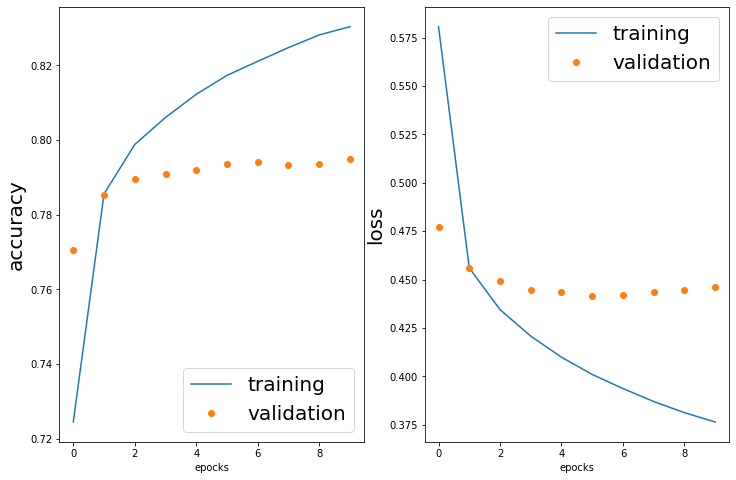

In [62]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

# 실험 결과
1. vocab size = 8000, model_type = bpe 일 때

> LSTM 
```
1537/1537 - 6s - loss: 0.4196 - accuracy: 0.8348 - 6s/epoch - 4ms/step
[0.41956353187561035, 0.8348386883735657]
```

> 1-D CNN
```
1537/1537 - 4s - loss: 1.1662 - accuracy: 0.7817 - 4s/epoch - 3ms/step
[1.1662278175354004, 0.7817038893699646]
```

> Global Max Pooling
```
1537/1537 - 3s - loss: 0.4817 - accuracy: 0.8334 - 3s/epoch - 2ms/step
[0.4816548824310303, 0.8333536982536316]
```

2. vocab size = 10000, model_type = bpe 일 때

> LSTM 
```
1537/1537 - 7s - loss: 0.4194 - accuracy: 0.8371 - 7s/epoch - 5ms/step
[0.4194413721561432, 0.8370763659477234]
```

> 1-D CNN
```
1537/1537 - 5s - loss: 1.1183 - accuracy: 0.7455 - 5s/epoch - 3ms/step
[1.1182972192764282, 0.745514452457428]
```

> Global Max Pooling
```
1537/1537 - 4s - loss: 0.4168 - accuracy: 0.8358 - 4s/epoch - 3ms/step
[0.4167833626270294, 0.8357744216918945]
```



3. vocab size = 10000, model_type = unigram(default) 일 때

> LSTM 
```
1537/1537 - 7s - loss: 0.3842 - accuracy: 0.8381 - 7s/epoch - 5ms/step
[0.3842264413833618, 0.8380731344223022]
```

> 1-D CNN
```
1537/1537 - 5s - loss: 1.1931 - accuracy: 0.7818 - 5s/epoch - 3ms/step
[1.1930625438690186, 0.781846284866333]
```

> Global Max Pooling
```
1537/1537 - 4s - loss: 0.4721 - accuracy: 0.8319 - 4s/epoch - 3ms/step
[0.4721464216709137, 0.8319296836853027]
```



4. vocab size = 10000, model_type = char 일 때

> LSTM 
```
1537/1537 - 7s - loss: 0.3872 - accuracy: 0.8224 - 7s/epoch - 4ms/step
[0.3871708810329437, 0.8224093914031982]
```

> 1-D CNN -> 오버피팅 발생!!!
```
1537/1537 - 4s - loss: 0.4319 - accuracy: 0.8254 - 4s/epoch - 3ms/step
[0.43188703060150146, 0.8253793716430664]
```

> Global Max Pooling
```
1537/1537 - 3s - loss: 0.4471 - accuracy: 0.7967 - 3s/epoch - 2ms/step
[0.4470667541027069, 0.7966556549072266]
```

**=> 형태소 분석기를 썼을 때와 정확도 차이가 크게 안난다.**

# 회고
---
> - 처음에 데이터 불러오는 방법이 여러가지고 코드가 익숙하지 않아 많이 헤맸다. 이제 이런 일 없도록 해야겠다.
> - NLP 텍스트 전처리 과정이 명확하게 머리에 안그려지는 상황에서 SentenciePiece를 활용하려고 하다보니 데이터 로더 함수를 짜는데도 시간이 좀 소요되었다. 텍스트 전처리할때 토크나이저 패키지를 잘 활용할 줄 아는 것도 효율적으로 시간을 쓸 수 있는 방법이라는 것을 깨달았다.
> - Korpora 라는 오픈소스 패키지를 발겼했다. 한국어 텍스트 데이터를 바로 불러와서 쓸 수 있는 유용한 패키지 같은데 다음에 한번 활용해봐야겠다.
> - **근데 아직 SentencePiece로 만든 토크나이저 함수를 활용할 때 불용어 제거를 어느 부분에서 해야할 지 모르겠다. 이부분은 자연어처리 고수분에게 물어보고 넘어가자.**
> - 불용어 제거할 때, 한국어는 불용어 제거 패키지가 없어 직접 불용어 사전을 만들어야 한다고 했다. 하지만 한국어 불용어 모음 텍스트 파일을 공유하기도 하니 불용어 사전을 만들 때 이것을 가져와 쓰거나 아니면 필요한 부분만 가져와서 사용하는 것도 좋을 것 같다.
> - 단어장 만들 때 vocab_size 와 model_type을 바꿔가면서 정확도가 어떻게 달라지는 지 실험을 했는데 LSTM & Global Max Pooling 과 1-D CNN이 반비례 처럼 달라졌다. 같은 모델 타입(bpe)에서 vocab_size를 더 크게 잡았을 땐, LSTM 과 GMP는 정확도가 조금 증가하였지만 1-D CNN은 오히려 더 떨어졌다. 그리고 마지막에 model_type default인 unigram으로 단어장을 만들어 학습시켰을 때는 LSTM, GMP는 정확도가 떨어졌지만 1-D CNN은 정확도가 80%가 넘으면 많이 올랐다.
> - 단순한 모델을 사용했기 때문에 다음엔 더 공부해서 Transformer와 BERT도 사용하고 워드 벡터 차원, 에포크 수도 늘려서 학습시켜볼 예정이다.
> - 그때는 오버피팅도 해결하면서 학습시켜보는걸로!

> **다음에 할 것을 정리해보자면**
> 1. 단어장을 네이버 영화 리뷰 말고 더 큰 한국어 텍스트로 만들어보기
> 2. 불용어 제거하는 방법 찾아서 불용어 제거하고 Sentencepiece 토크나이저 돌리기
> 3. 좀 더 복잡한 모델 transformer로 돌리기
> 4. 오버피팅나면 정규화해서 학습시키기